# Short Put Option

### I. Strategy Overview

* This is one of the most basic option strategy composed of a single short put leg.  
* One common use of this strategy is to acquire stocks at your desired price by selling out the money put. At expiration if the underlying price falls below your strike price, the stocks will be asigned to you at the strike price, and you will get addition premium for selling the option. 
* This strategy needs large buying power requirement

#### Payoff
Option Payoff or Profit and Loss (P&L) diagrams help us understand where our options strategies win or lose money at expiration based on different stock price points.

![](short_put.jpg)

#### Features (optional):
* Long Delta: profit of the strategy increases as the underlying price goes up
* Long Theta: profit of the strategy increases as time decays
* Short volatility: profit of the strategy increases as the implied volatility drops

### II. Strategy Setup
* Observe the historical price of selected underlying
* Find avaialble expiration dates for options
* Select an expiration date, option type and stike price for the option strategy
* Select entrance and exit point (simplified by choosing future enter and exit dates)

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from Functions.mainprg import GetDays, GetPayOff, GetBackTesting, GetPriceHistory
import pandas as pd
import numpy as np
from datetime import timedelta

####  a. Select underlying by ticker

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


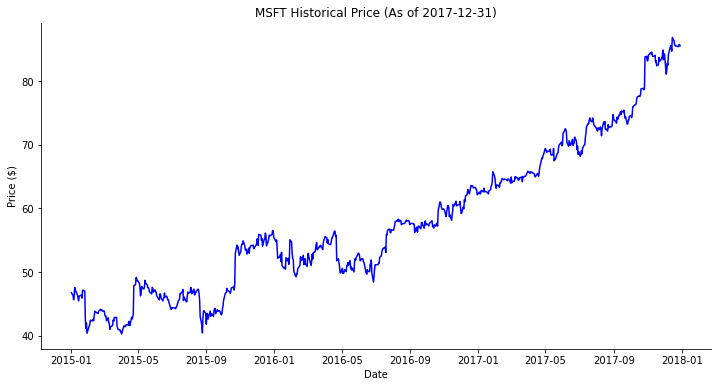

In [2]:
Ticker = 'MSFT'
GetPriceHistory(Ticker).plot_price_history()

#### b. Find expiration dates for testing period

In [3]:
Start_Date = datetime.datetime(2018, 1, 4)
End_Date = datetime.datetime(2018,6, 30)

GetDays(Ticker, Start_Date, End_Date, []).expiration_dates

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Expiration Date,Day of the Week,Year-Month,Expiration
0,2018-01-19,Friday,2018-01,1
1,2018-02-16,Friday,2018-02,1
2,2018-03-16,Friday,2018-03,1
3,2018-04-20,Friday,2018-04,1
4,2018-05-18,Friday,2018-05,1
5,2018-06-15,Friday,2018-06,1


#### c. Select an expiration date, choose option type (call) and strike price

In [4]:
expiration = datetime.datetime(2018, 3, 18)
option_type = ['P']  # C(all), P(ut)
action = ['S']  #L(ong), S(hort)

# Change the strike price to see how it affects the strategy
# strike_price = [85]  # At the money
strike_price = [80]  # Deep in the money
#strike_price = 95  # Far out the money

#### d. Choose option enter and exit dates

In [5]:
entry_date = datetime.datetime(2018, 1, 2)
exit_date = datetime.datetime(2018, 3, 5)

### III. Visualization
#### a. Generate option(s) price and payoff

Option Premium = $0.24


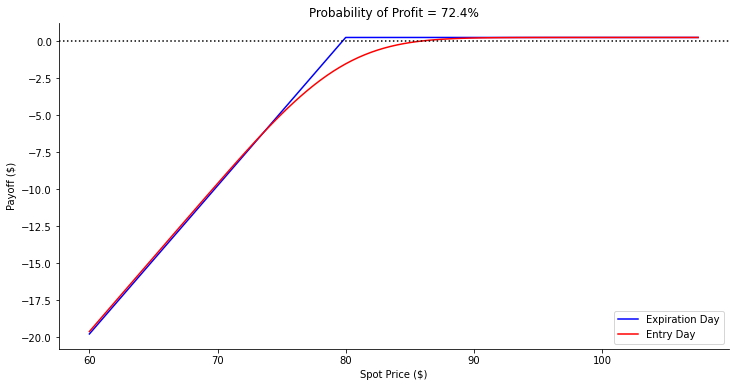

In [6]:
payoff = GetPayOff(Ticker, strike_price, entry_date, expiration, option_type, action)
print('Option Premium = '+"${:.2f}".format(payoff.option_price[0]))
payoff.plot_payoff()

#### * Note that the probability of profit for this strategy is rather, as tradeoff the max profit is relatively low.

##### b. Compare returns by holding the option vs. buy&hold the underlying

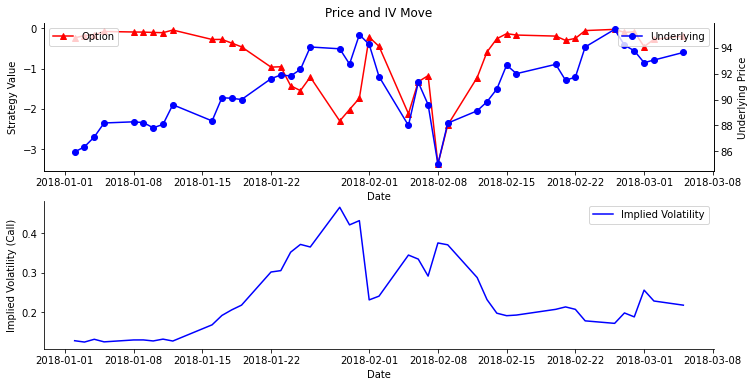

In [7]:
bt1 = GetBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type, action)
bt1.plot_price_history()

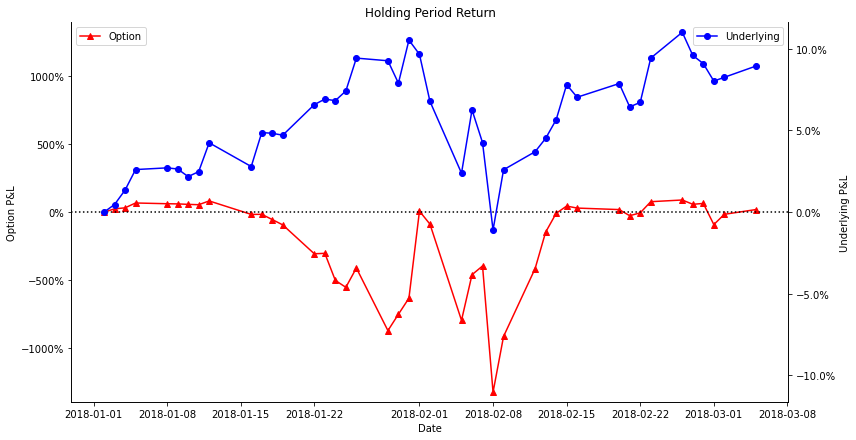

In [8]:
bt1.plot_option_pnl()

#### c. Strategy Summary

In [9]:
bt1.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2018-01-02,$-23.69,2018-03-05,62,$-19.28,$4.41,$0.07,18.6%,True


### III. Recurring Strategy Setup

#### a. Choose the backtesting period for the recurring startegy

In [16]:
Start_Date = datetime.datetime(2016, 1, 4)
End_Date = datetime.datetime(2018,8, 30)

expiry = GetDays(Ticker, Start_Date, End_Date, []).expiration_dates
trading_days = GetDays(Ticker, Start_Date, End_Date, []).trading_days
trading_days['Year-Month'] = pd.to_datetime(trading_days['Date']).dt.to_period('M') + 1  # +1 to find the expiration date in the next month

dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Expiration Date']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### b. Set trading rules

#### Simplified (current):
* Enter: 43 days before expriation
* Exit: 21 days before expiration
* Strike prices = enter day underlying price - \\$5


In [26]:
entry_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True))
expiration_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Expiration Date'].reset_index(drop=True))
exit_dates = entry_dates + timedelta(days=24)
expiration_dates = pd.to_datetime(expiration_dates)

#### c. Run recursive analysis

In [18]:
strategy_performance = pd.DataFrame([])
strat_sum_for_stats = []
strike_price = [35]
i = 0
for _ in entry_dates:
    bt = GetBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    strategy_performance = strategy_performance.append(bt.strategy_summary)
    strat_sum_for_stats.append(bt.strat_sum_for_stats)
    i += 1
    end_of_period_spot = bt.underlying_price_truncated_['close'][-1]
    strike_price = [end_of_period_spot-5]
    
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))

In [19]:
win_rate

'77.42%'

In [20]:
strategy_performance.reset_index(drop=True, inplace=True)
strategy_performance

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2016-01-07,$-0.00,2016-01-31,24,$-0.00,$0.00,$0.00,100.0%,True
1,2016-02-04,$-125.04,2016-02-28,24,$-114.02,$11.02,$0.46,8.8%,True
2,2016-03-03,$-7.93,2016-03-27,24,$-0.24,$7.70,$0.32,97.0%,True
3,2016-04-07,$-28.67,2016-05-01,24,$-109.58,$-80.91,$-3.37,-282.2%,False
4,2016-05-05,$-12.99,2016-05-29,24,$-0.10,$12.88,$0.54,99.2%,True
5,2016-06-02,$-3.41,2016-06-26,24,$-70.21,$-66.79,$-2.78,-1956.2%,False
6,2016-07-07,$-7.29,2016-07-31,24,$-0.00,$7.29,$0.30,100.0%,True
7,2016-08-04,$-2.32,2016-08-28,24,$-0.46,$1.86,$0.08,80.0%,True
8,2016-09-08,$-4.11,2016-10-02,24,$-4.46,$-0.35,$-0.01,-8.6%,False
9,2016-10-06,$-15.61,2016-10-30,24,$-1.67,$13.93,$0.58,89.3%,True


In [24]:
strategy_performance['Cost Basis']
avg_cost =strategy_performance['Cost Basis'].str.strip('$').astype(float).mean()
print('Mean Cost: ', "${:.2f}".format(-avg_cost)) 

Mean Cost:  $32.19


#### *Note that this cost is not accurate.  Actual cost is the buying power effect, which is substantial

In [21]:
strategy_performance['P&L']
pnl_sum =strategy_performance['P&L'].str.strip('$').astype(float).sum()
print('Total Profit: ', "${:.2f}".format(pnl_sum))

Total Profit:  $216.24
